In [1]:
# ------------------------------------------------------------
# 1. Importations
# ------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import pickle


In [2]:
# ------------------------------------------------------------
# 2. Chemins
# ------------------------------------------------------------
DATASET_PATH = "../data/flower_images"
MODEL_BASELINE_PATH = "../models/inception_baseline.h5"
MODEL_FINETUNED_PATH = "../models/inception_finetuned.h5"
HISTORY_FINETUNE_PATH = "../models/history_finetune.pkl"

print("Dataset :", DATASET_PATH)
print("Classes :", os.listdir(DATASET_PATH))


Dataset : ../data/flower_images
Classes : ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [3]:
# ------------------------------------------------------------
# 3. Paramètres
# ------------------------------------------------------------
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 10     # pour fine-tuning
LR = 1e-5      # très faible learning rate


In [4]:
# ------------------------------------------------------------
# 4. Générateurs
# ------------------------------------------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [5]:
# ------------------------------------------------------------
# 5. Charger le modèle baseline entraîné
# ------------------------------------------------------------
print("\nChargement du modèle baseline...")
baseline_model = load_model(MODEL_BASELINE_PATH)

baseline_model.summary()



Chargement du modèle baseline...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../models/inception_baseline.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
# ------------------------------------------------------------
# 6. Déverrouiller certaines couches (fine-tuning)
# ------------------------------------------------------------
print("\nDégel des couches profondes pour fine-tuning...\n")

fine_tune_at = 250  # on laisse 250 premières couches gelées → stable

for layer in baseline_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in baseline_model.layers[fine_tune_at:]:
    layer.trainable = True


Couches entraînables : 53
Couches gelées : 261


In [20]:

# ------------------------------------------------------------
# 7. Compilation
# ------------------------------------------------------------
baseline_model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [21]:

# ------------------------------------------------------------
# 8. Entraînement
# ------------------------------------------------------------
history_finetune = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


In [24]:

# ------------------------------------------------------------
# 9. Sauvegarder modèle + historique
# ------------------------------------------------------------
print("\n Sauvegarde du modèle fine-tuned…")
baseline_model.save(MODEL_FINETUNED_PATH)

with open(HISTORY_FINETUNE_PATH, "wb") as f:
    pickle.dump(history_finetune.history, f)

print("✔ Modèle sauvegardé :", MODEL_FINETUNED_PATH)
print("✔ Historique sauvegardé :", HISTORY_FINETUNE_PATH)



 Sauvegarde du modèle fine-tuned…


NameError: name 'baseline_model' is not defined

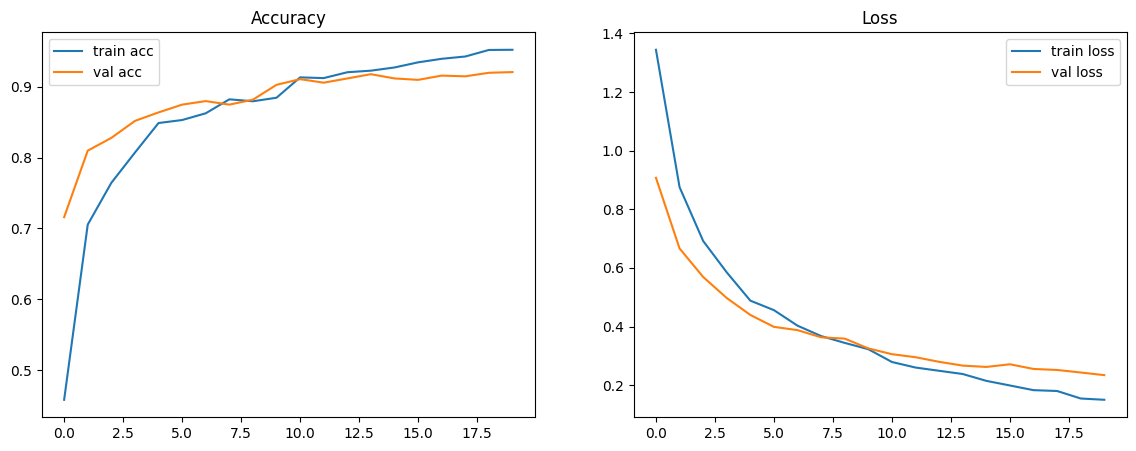

In [23]:

# ------------------------------------------------------------
# 10. Visualisation
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(history_finetune.history["accuracy"], label="Train Acc FT")
plt.plot(history_finetune.history["val_accuracy"], label="Val Acc FT")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Fine-Tuning InceptionV3")
plt.legend()
plt.grid()
plt.show()
